## N번 촬영한 마커 이미지를 평균

In [5]:
import os
import json
import cv2
import numpy as np
from collections import defaultdict
from scipy.spatial.transform import Rotation as R

# 디렉토리 설정
base_dirs = [
    "./ArUco_cap_250514",
    "./ArUco_cap2_250514",
    "./ArUco_cap3_250514"
]
output_dir = "./Correct_ArUco"
os.makedirs(output_dir, exist_ok=True)

# 파일 이름에서 뷰와 카메라 추출
def parse_filename(filename):
    parts = filename.split('_')
    view = parts[0]
    cam = parts[2]
    return view, cam

# 데이터 구조: data[view][cam][marker_id] = list of marker dicts
data = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

# 파일 수집 및 데이터 적재
for base_dir in base_dirs:
    for fname in os.listdir(base_dir):
        if not fname.endswith('.json'):
            continue
        view, cam = parse_filename(fname)
        with open(os.path.join(base_dir, fname), 'r') as f:
            content = json.load(f)
            for marker_id, marker_data in content.items():
                data[view][cam][marker_id].append(marker_data)

# 회전 평균
def average_quaternion(quaternions):
    M = np.zeros((4, 4))
    for q in quaternions:
        q = q.reshape(4, 1)
        M += q @ q.T
    eigvals, eigvecs = np.linalg.eigh(M)
    avg_quat = eigvecs[:, np.argmax(eigvals)]
    return avg_quat / np.linalg.norm(avg_quat)

# 위치 평균
def average_position(positions):
    return np.mean(positions, axis=0)

# 마커 정리 및 저장
for view in data: # ['top', 'right', 'front', 'left']
    for cam in data[view]: # ['leftcam', 'rightcam']
        corrected = {}
        for marker_ids, entries in data[view][cam].items():
            if len(entries) < 2:
                continue  # 최소 두 개 이상 있어야 평균
            positions = [np.array([m['position_m']['x'], m['position_m']['y'], m['position_m']['z']]) for m in entries]
            quaternions = [np.array([m['rotation_quat']['x'], m['rotation_quat']['y'],
                                    m['rotation_quat']['z'], m['rotation_quat']['w']]) for m in entries]

            avg_pos = average_position(positions)
            avg_quat = average_quaternion(quaternions)

            corrected[marker_ids] = {
                "position_m": {"x": float(avg_pos[0]), "y": float(avg_pos[1]), "z": float(avg_pos[2])},
                "rotation_quat": {"x": float(avg_quat[0]), "y": float(avg_quat[1]),
                                "z": float(avg_quat[2]), "w": float(avg_quat[3])},
                "corners_pixel": entries[0]["corners_pixel"]
            }

        output_path = os.path.join(output_dir, f"{view}_{cam}_corrected.json")
        with open(output_path, 'w') as f:
            json.dump(corrected, f, indent=4)

print("보정된 결과가 다음 디렉토리에 저장되었습니다:", output_dir)

보정된 결과가 다음 디렉토리에 저장되었습니다: ./Correct_ArUco


## 평균값에서 회전은 동일하다고 가정하여, 거리별 가중치 노이즈 제거하여 회전 벡터 구하기

In [ ]:
import os
import json
import numpy as np
from scipy.spatial.transform import Rotation as R
from collections import defaultdict

# 디렉토리 설정
corrected_dirs = "./Correct_ArUco"
output_dir = "./Rot_Tvec_corrected_ArUco"
os.makedirs(output_dir, exist_ok=True)

# 파일 이름에서 뷰와 카메라 추출
def parse_filename(filename):
    parts = filename.split('_')
    view = parts[0]
    cam = parts[1]
    return view, cam

# 데이터 구조: data[view][cam][marker_id] = list of marker dicts
data = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

# 파일 수집 및 데이터 적재
for fname in os.listdir(corrected_dirs):
    if not fname.endswith('.json'):
        continue
    view, cam = parse_filename(fname)
    with open(os.path.join(corrected_dirs, fname), 'r') as f:
        content = json.load(f)
        for marker_id, marker_data in content.items():
            data[view][cam][marker_id].append(marker_data)

ANGLE_THRESH_DEG = 1.5  # 회전 이상치 판정 임계각

for view, cams in data.items():
    for cam, markers in cams.items():
        # (1) 포즈 수집
        tvecs, quats, ids = [], [], []
        for marker_id, entries in markers.items():
            m = entries[0]
            tvecs.append([m['position_m'][k] for k in ('x', 'y', 'z')])
            quats.append([m['rotation_quat'][k] for k in ('x', 'y', 'z', 'w')])
            ids.append(marker_id)

        tvecs = np.array(tvecs)
        quats = np.array(quats)
        N = len(ids)

        if N < 2:
            print(f"{view}/{cam}: 마커 {N}개라 스킵")
            continue

        # (2) 거리 가중치
        dists = np.linalg.norm(tvecs, axis=1)
        weights = 1.0 / (dists + 1e-6)
        weights /= weights.sum()

        # (3) 회전 이상치 제거
        def total_angdist(qi, all_q):
            dots = np.abs(np.dot(all_q, qi))
            return np.sum(2 * np.arccos(np.clip(dots, -1, 1)))

        scores = [total_angdist(quats[i], quats) for i in range(N)]
        q_med = quats[np.argmin(scores)]
        dots = np.abs(np.dot(quats, q_med))
        thetas = 2 * np.arccos(np.clip(dots, -1, 1))
        mask = thetas < np.deg2rad(ANGLE_THRESH_DEG)

        excluded = [ids[i] for i in range(N) if not mask[i]]
        if excluded:
            print(f"[{view}/{cam}] 제외된 마커 (θ≥{ANGLE_THRESH_DEG}°): {excluded}")
        if mask.sum() < 2:
            print(f"{view}/{cam}: inlier <2 → 스킵")
            continue

        # (4) 회전 평균 (inlier만 사용)
        quats_f = quats[mask]
        w_f = weights[mask]
        w_f /= w_f.sum()

        M = sum(w * np.outer(q, q) for q, w in zip(quats_f, w_f))
        eigvals, eigvecs = np.linalg.eigh(M)
        q_mean = eigvecs[:, np.argmax(eigvals)]
        q_mean /= np.linalg.norm(q_mean)

        # (5) 출력 JSON 생성 & 저장 (inlier만 저장, tvec은 원래 값 유지)
        inlier_ids = [ids[i] for i in range(N) if mask[i]]
        corrected_output = {}
        for mid in inlier_ids:
            corrected_output[mid] = {
                "position_m": markers[mid][0]["position_m"],  # 원래 위치 그대로
                "rotation_quat": {
                    "x": float(q_mean[0]),
                    "y": float(q_mean[1]),
                    "z": float(q_mean[2]),
                    "w": float(q_mean[3])
                },
                "corners_pixel": markers[mid][0]["corners_pixel"]
            }

        # (6) 파일 저장
        out_fname = f"{view}_{cam}_RotTvec_corrected.json"
        with open(os.path.join(output_dir, out_fname), "w") as fout:
            json.dump(corrected_output, fout, indent=4)

        print(f"[{view}/{cam}] 저장: {out_fname}")


[left/leftcam] 제외된 마커 (θ≥1.5°): ['4']
[left/leftcam] 저장: left_leftcam_RotTvec_corrected.json
[left/rightcam] 제외된 마커 (θ≥1.5°): ['4']
[left/rightcam] 저장: left_rightcam_RotTvec_corrected.json
[top/leftcam] 제외된 마커 (θ≥1.5°): ['8', '5']
[top/leftcam] 저장: top_leftcam_RotTvec_corrected.json
[top/rightcam] 제외된 마커 (θ≥1.5°): ['8']
[top/rightcam] 저장: top_rightcam_RotTvec_corrected.json
[right/leftcam] 제외된 마커 (θ≥1.5°): ['8']
[right/leftcam] 저장: right_leftcam_RotTvec_corrected.json
[right/rightcam] 제외된 마커 (θ≥1.5°): ['8']
[right/rightcam] 저장: right_rightcam_RotTvec_corrected.json
[front/leftcam] 제외된 마커 (θ≥1.5°): ['1', '6']
[front/leftcam] 저장: front_leftcam_RotTvec_corrected.json
[front/rightcam] 제외된 마커 (θ≥1.5°): ['2', '1', '6']
[front/rightcam] 저장: front_rightcam_RotTvec_corrected.json


### 1. 마커별로 Tvec과 Rvec를 계산한다.
### 2. 해당 값으로 각각 카메라 좌표계를 기준으로 로봇의 위치를 추정한다.
### 3. 추정된 위치의 평균을 구한다.

[front] 평균 베이스 위치: [ 0.03182497 -0.39810124  0.81454917]
[front] 좌표별 표준편차: [0.00115697 0.00095988 0.00184848]


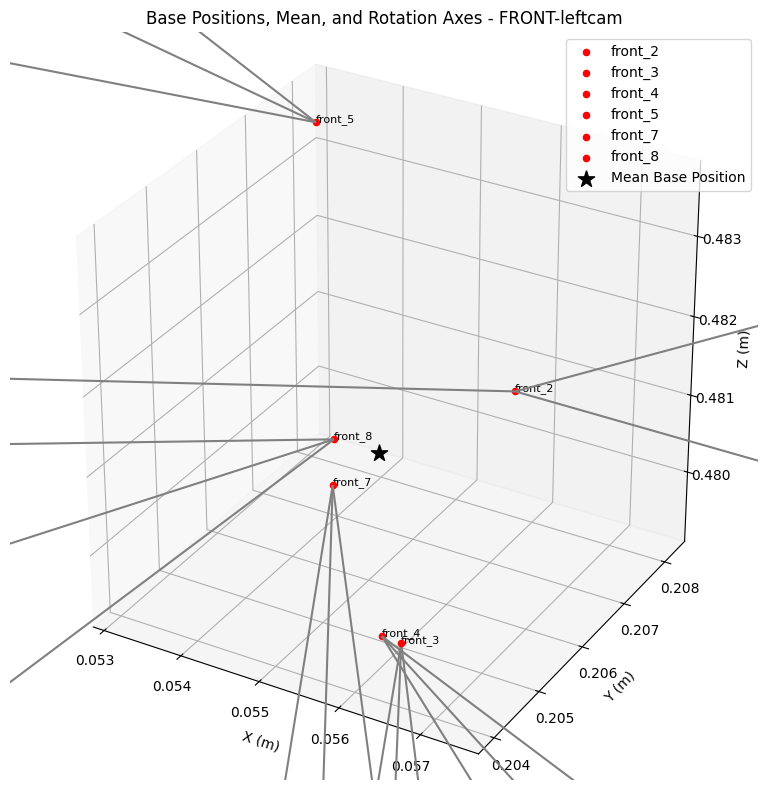

[front] 평균 베이스 위치: [0.05528942 0.2057447  0.48095904]
[front] 좌표별 표준편차: [0.00107618 0.00078234 0.00168825]


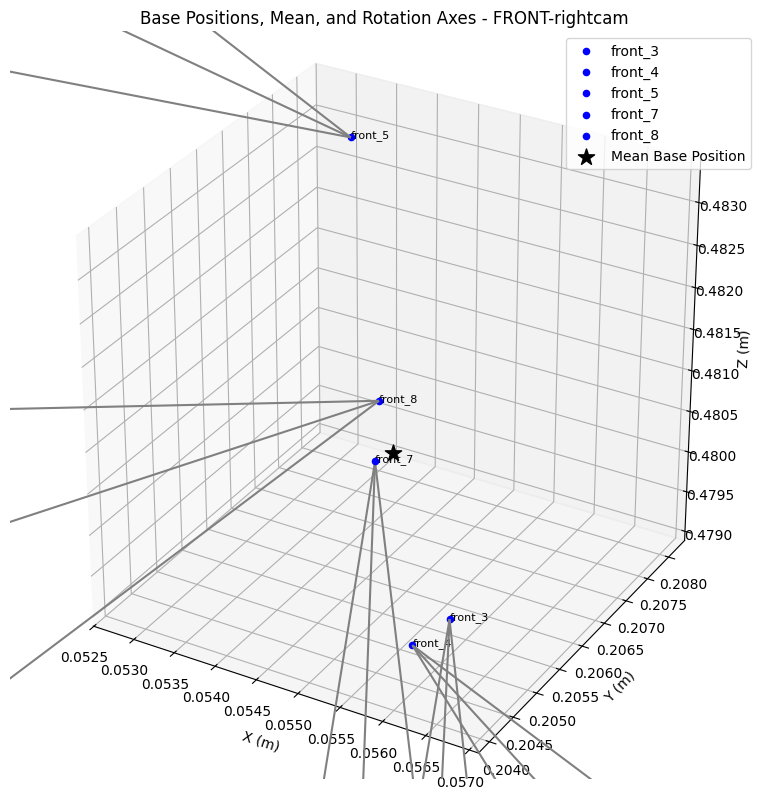

[left] 평균 베이스 위치: [0.05489335 0.20590614 0.48061202]
[left] 좌표별 표준편차: [0.00077439 0.000725   0.00164264]


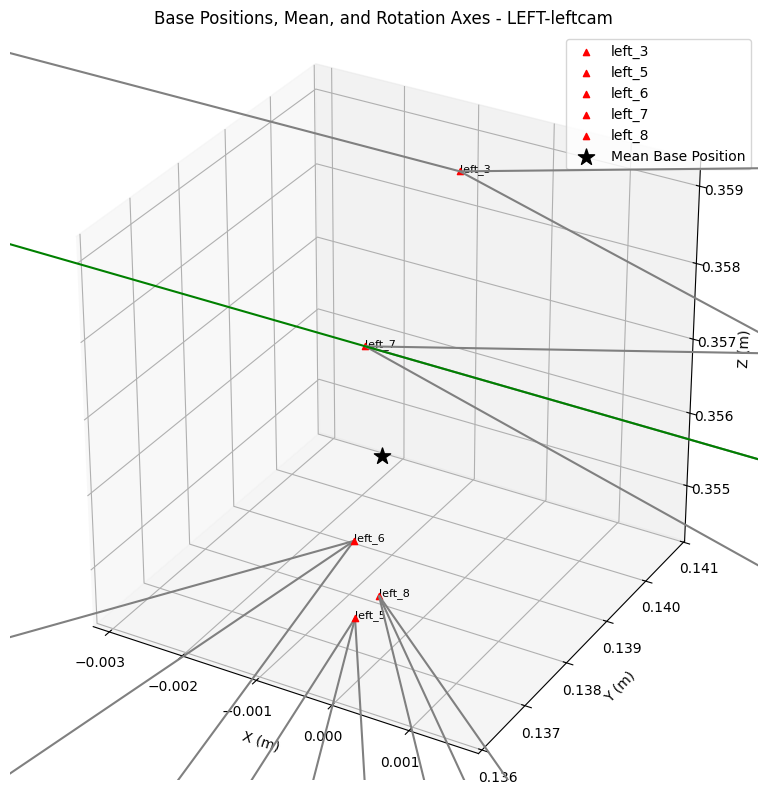

[left] 평균 베이스 위치: [-0.00066899  0.13820567  0.35610739]
[left] 좌표별 표준편차: [0.00029375 0.00068423 0.00194636]


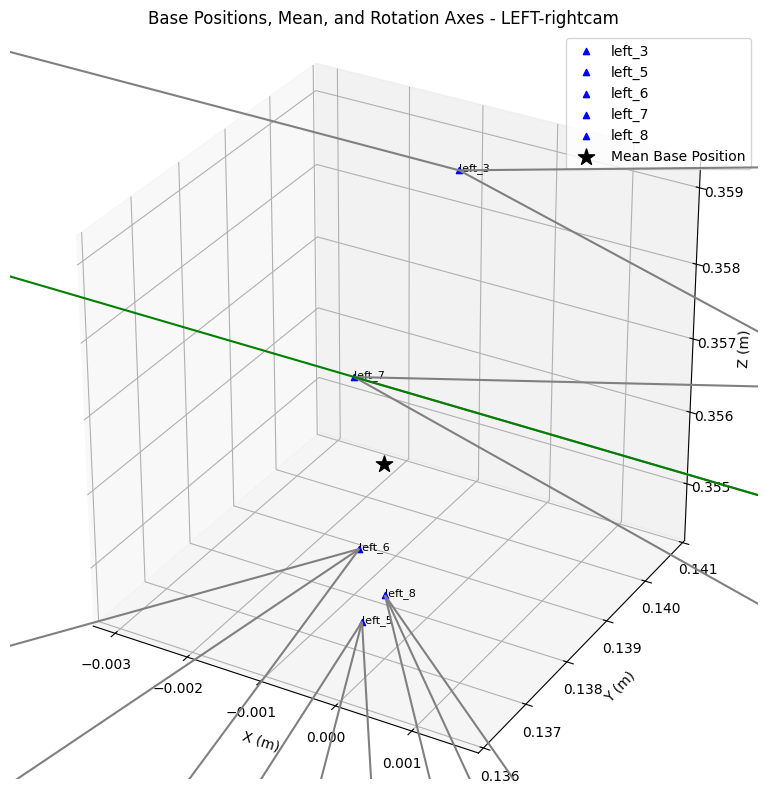

[right] 평균 베이스 위치: [-0.00067876  0.13815349  0.35602167]
[right] 좌표별 표준편차: [0.00031842 0.00069961 0.00192541]


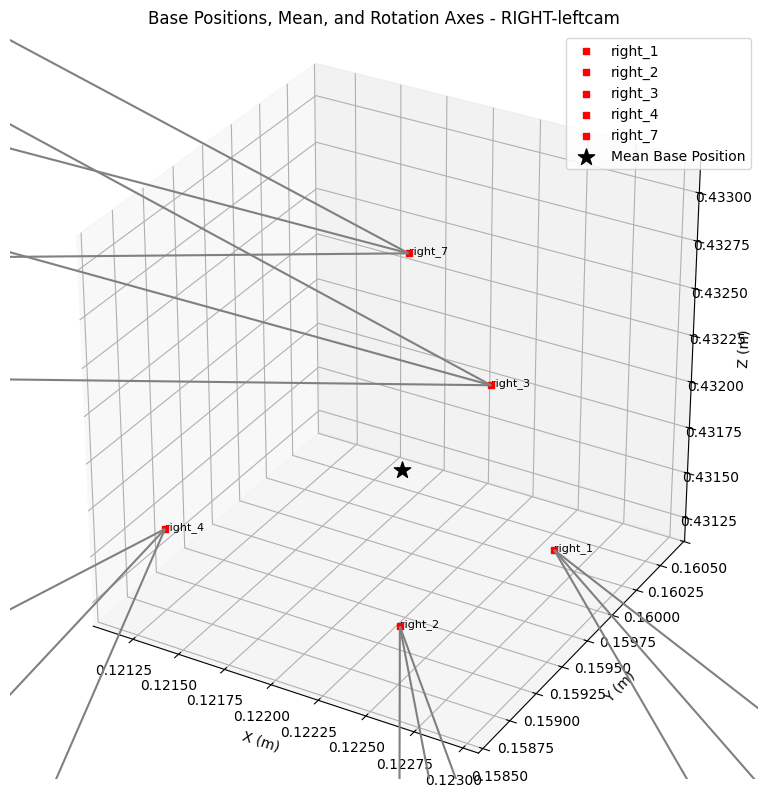

[right] 평균 베이스 위치: [0.12221536 0.15927575 0.43189898]
[right] 좌표별 표준편차: [0.00066163 0.00031443 0.0006778 ]


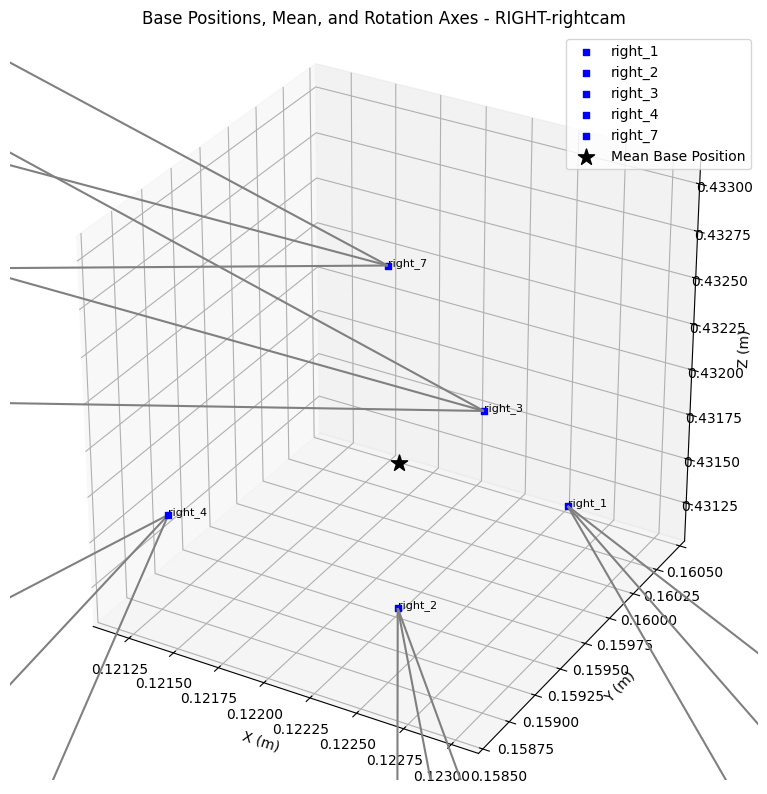

[top] 평균 베이스 위치: [0.12223224 0.1593157  0.43185042]
[top] 좌표별 표준편차: [0.00067234 0.00028751 0.00064455]


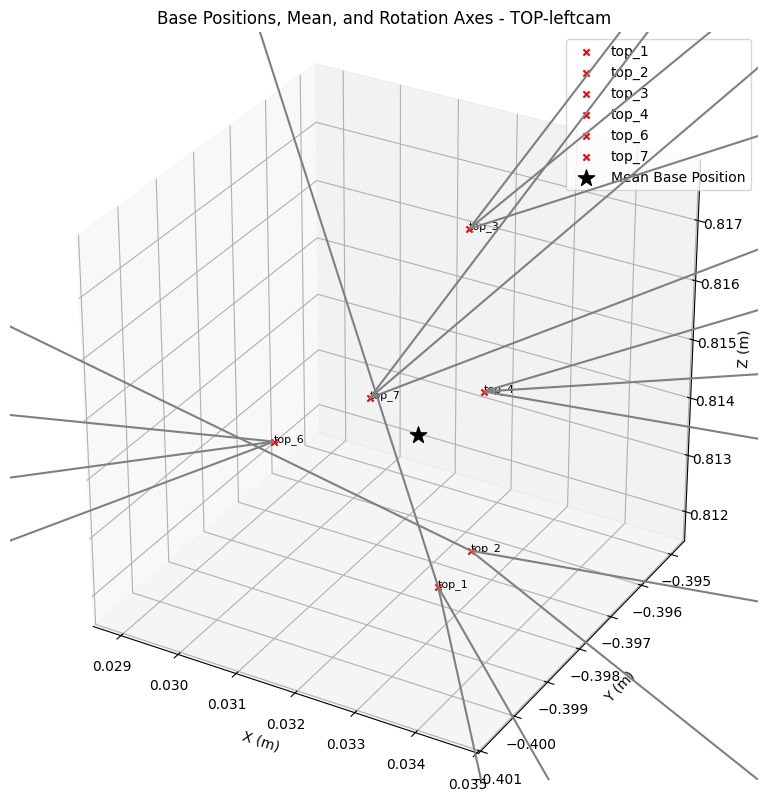

[top] 평균 베이스 위치: [ 0.03220504 -0.39787042  0.81422066]
[top] 좌표별 표준편차: [0.00095634 0.00068172 0.00207159]


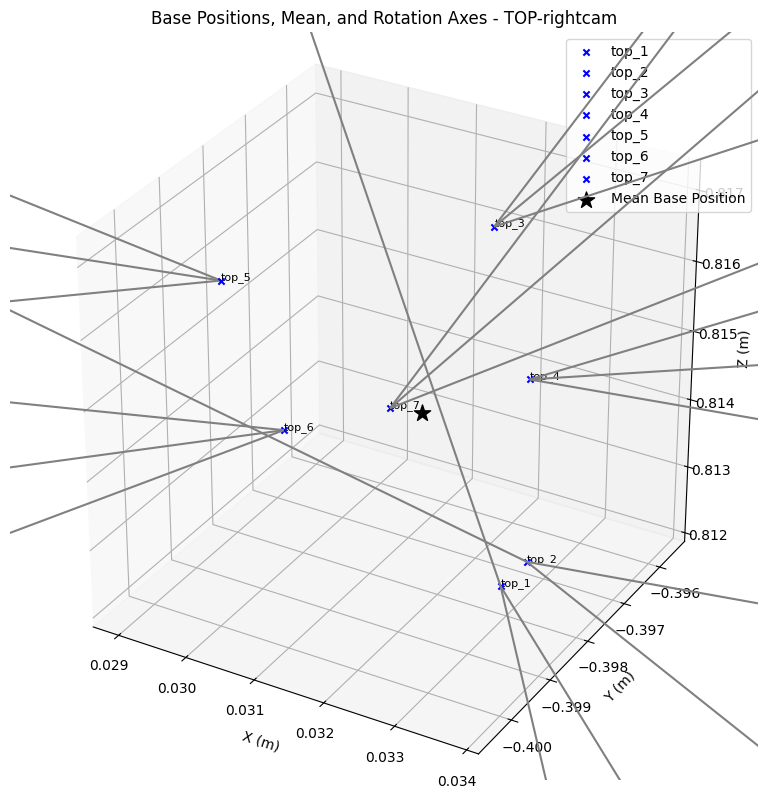

In [27]:
# Re-import necessary libraries after code execution state reset
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# 설정
base_dir = "./Rot_Tvec_corrected_ArUco"
views = ['front', 'left', 'right', 'top']
cams = ['leftcam', 'rightcam']

marker_offsets = {
    "front": {
        "1": np.array([-0.100, 0.125, 0]),
        "2": np.array([-0.100, 0.025, 0]),
        "3": np.array([0, -0.175, 0]),
        "4": np.array([-0.100, -0.075, 0]),
        "5": np.array([0.125, 0.025, 0]),
        "6": np.array([0.125, 0.125, 0]),
        "7": np.array([0, -0.075, 0]),
        "8": np.array([0.125, -0.075, 0]),
    },
    "left": {
        "3": np.array([0, -0.175, 0]),
        "4": np.array([-0.100, -0.075, 0]),
        "5": np.array([0.125, 0.025, 0]),
        "6": np.array([0.125, 0.125, 0]),
        "7": np.array([0.000, -0.075, 0]),
        "8": np.array([0.125, -0.075, 0]),
    },
    "right": {
        "1": np.array([-0.100, 0.125, 0]),
        "2": np.array([-0.100, 0.025, 0]),
        "3": np.array([0.000, -0.175, 0]),
        "4": np.array([-0.100, -0.075, 0]),
        "7": np.array([0.000, -0.075, 0]),
        "8": np.array([0.125, -0.075, 0]),
    },
    "top": {
        "1": np.array([-0.100, 0.125, 0]),
        "2": np.array([-0.100, 0.025, 0]),
        "3": np.array([0, -0.175, 0]),
        "4": np.array([-0.100, -0.075, 0]),
        "5": np.array([0.125, 0.025, 0]),
        "6": np.array([0.125, 0.125, 0]),
        "7": np.array([0, -0.075, 0]),
        "8": np.array([0.125, -0.075, 0]),
    },
}

markers = {'front': 'o', 'left': '^', 'right': 's', 'top': 'x'}
colors = {'leftcam': 'red', 'rightcam': 'blue'}

unit_axes = {'x': np.array([1, 0, 0]), 'y': np.array([0, 1, 0]), 'z': np.array([0, 0, 1])}
axis_colors = {'x': 'red', 'y': 'green', 'z': 'blue'}

# Re-run the plotting logic
for view in views:
    for cam in cams:
        base_positions = []
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        json_path = os.path.join(base_dir, f"{view}_{cam}_RotTvec_corrected.json")
        if not os.path.exists(json_path):
            print(f"[{view}-{cam}] 파일 없음")
            continue

        with open(json_path, 'r') as f:
            corrected = json.load(f)

        for marker_id, offset in marker_offsets[view].items():
            if marker_id not in corrected:
                continue
            m = corrected[marker_id]
            pos = np.array([m["position_m"]["x"], m["position_m"]["y"], m["position_m"]["z"]])
            quat = np.array([m["rotation_quat"]["x"], m["rotation_quat"]["y"], m["rotation_quat"]["z"], m["rotation_quat"]["w"]])
            rot_mat = R.from_quat(quat).as_matrix()
            base_pos = pos + rot_mat @ offset
            base_positions.append(base_pos)

            for axis_name, unit_vec in unit_axes.items():
                rotated_vec = rot_mat @ unit_vec
                ax.quiver(pos[0], pos[1], pos[2], *rotated_vec, length=0.05, color=axis_colors[axis_name], normalize=True)

            ax.scatter(*base_pos, color=colors[cam], marker=markers[view], label=f'{view}_{marker_id}')
            ax.text(*base_pos, f'{view}_{marker_id}', color='black', fontsize=8)
            delta = base_pos - pos
            ax.quiver(pos[0], pos[1], pos[2], *delta, color='gray', length=np.linalg.norm(delta), normalize=True)
        print(f"[{view}] 평균 베이스 위치: {mean_base}")
        print(f"[{view}] 좌표별 표준편차: {std_base}")

        if len(base_positions) == 0:
            print(f"[{view}-{cam}] 베이스 좌표 없음")
            continue

        base_positions = np.array(base_positions)
        mean_base = np.mean(base_positions, axis=0)
        std_base = np.std(base_positions, axis=0)

        ax.scatter(*mean_base, color='black', marker='*', s=150, label='Mean Base Position')

        ranges = base_positions.max(axis=0) - base_positions.min(axis=0)
        max_range = np.max(ranges)
        mid_vals = (base_positions.max(axis=0) + base_positions.min(axis=0)) / 2
        ax.set_xlim(mid_vals[0] - max_range / 2, mid_vals[0] + max_range / 2)
        ax.set_ylim(mid_vals[1] - max_range / 2, mid_vals[1] + max_range / 2)
        ax.set_zlim(mid_vals[2] - max_range / 2, mid_vals[2] + max_range / 2)
        ax.set_box_aspect([1, 1, 1])

        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.set_zlabel('Z (m)')
        ax.set_title(f'Base Positions, Mean, and Rotation Axes - {view.upper()}-{cam}')
        ax.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


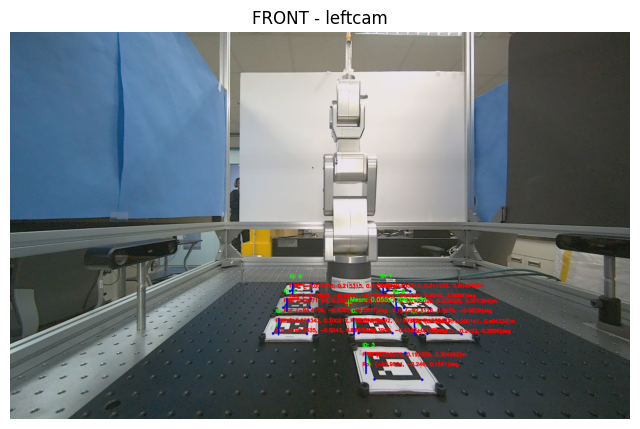

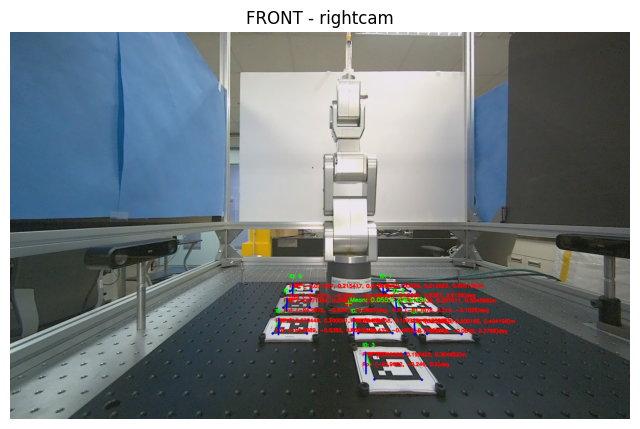

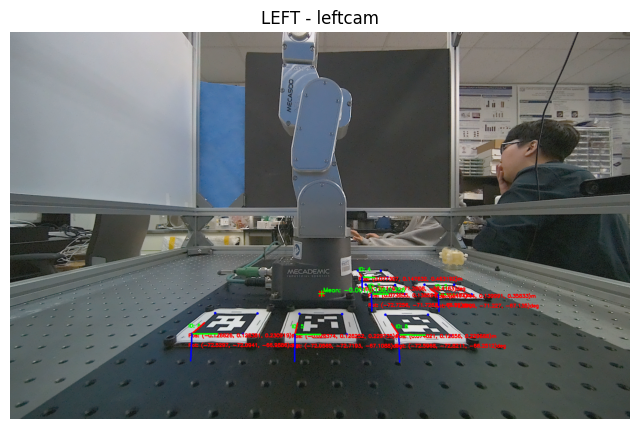

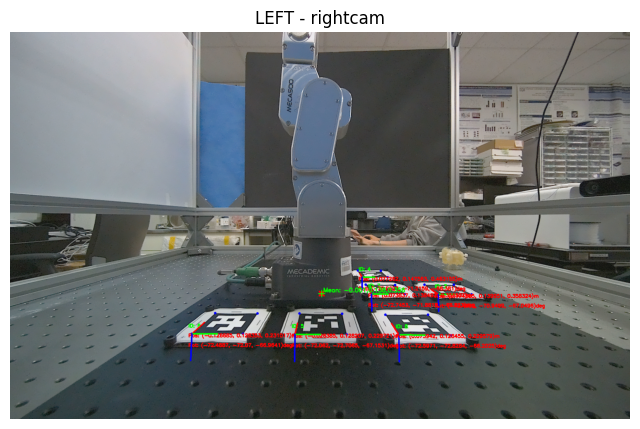

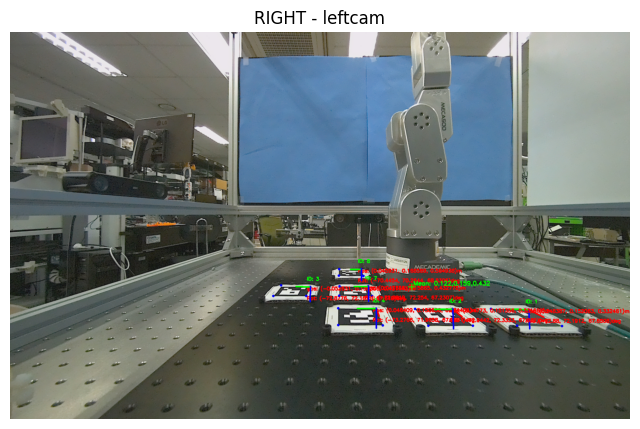

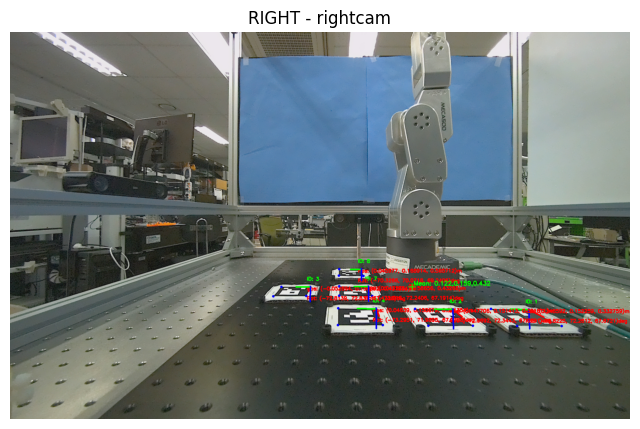

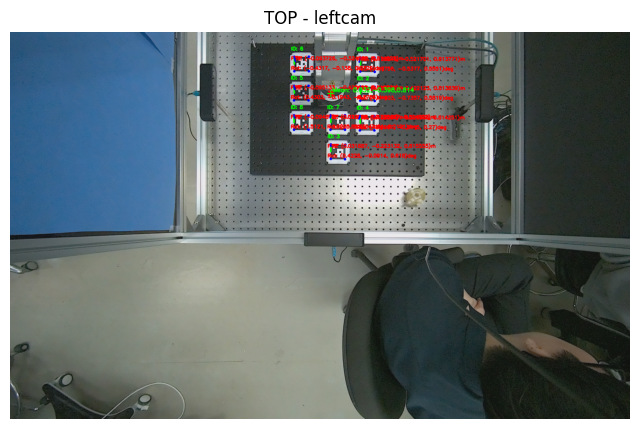

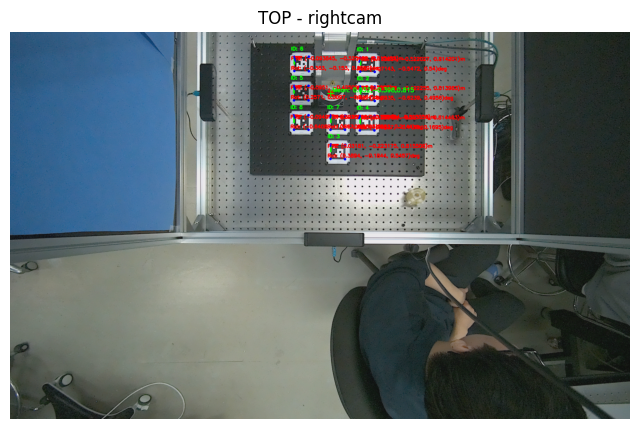

    view       cam    mean_x    mean_y    mean_z     std_x     std_y  \
0  front   leftcam  0.055289  0.205745  0.480959  0.001076  0.000782   
1  front  rightcam  0.054893  0.205906  0.480612  0.000774  0.000725   
2   left   leftcam -0.000669  0.138206  0.356107  0.000294  0.000684   
3   left  rightcam -0.000679  0.138153  0.356022  0.000318  0.000700   
4  right   leftcam  0.122215  0.159276  0.431899  0.000662  0.000314   
5  right  rightcam  0.122232  0.159316  0.431850  0.000672  0.000288   
6    top   leftcam  0.032205 -0.397870  0.814221  0.000956  0.000682   
7    top  rightcam  0.031825 -0.398101  0.814549  0.001157  0.000960   

      std_z  proj_x  proj_y  
0  0.001688    1048     841  
1  0.001643    1048     842  
2  0.001946     965     812  
3  0.001925     965     812  
4  0.000678    1244     791  
5  0.000645    1245     791  
6  0.002072     993     193  
7  0.001848     993     193  


In [7]:
import os
import glob
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import pandas as pd

# 설정
base_dir = "./Rot_Tvec_corrected_ArUco"
corner_json_dir = "./Rot_Tvec_corrected_ArUco"
image_dir = "/home/najo/NAS/ZED_Cap_make_dataset/ArUco_cap3_250514"
calib_dir = "./Calib_cam"
views = ['front', 'left', 'right', 'top']
cams = ['leftcam', 'rightcam']

# 시리얼 ↔ 위치 맵
camera_serials = {"front":41182735,"right":49429257,"left":44377151,"top":49045152}

# 마커 오프셋 (m)
marker_offsets = {
    "front": {"1":np.array([-0.100,0.125,0]),"2":np.array([-0.100,0.025,0]),
              "3":np.array([0,-0.175,0]),"4":np.array([-0.100,-0.075,0]),
              "5":np.array([0.125,0.025,0]),"6":np.array([0.125,0.125,0]),
              "7":np.array([0,-0.075,0]),"8":np.array([0.125,-0.075,0])},
    "left":  {"3":np.array([0,-0.175,0]),"4":np.array([-0.100,-0.075,0]),
              "5":np.array([0.125,0.025,0]),"6":np.array([0.125,0.125,0]),
              "7":np.array([0,-0.075,0]),"8":np.array([0.125,-0.075,0])},
    "right": {"1":np.array([-0.100,0.125,0]),"2":np.array([-0.100,0.025,0]),
              "3":np.array([0,-0.175,0]),"4":np.array([-0.100,-0.075,0]),
              "7":np.array([0,-0.075,0]),"8":np.array([0.125,-0.075,0])},
    "top":   {"1":np.array([-0.100,0.125,0]),"2":np.array([-0.100,0.025,0]),
              "3":np.array([0,-0.175,0]),"4":np.array([-0.100,-0.075,0]),
              "5":np.array([0.125,0.025,0]),"6":np.array([0.125,0.125,0]),
              "7":np.array([0,-0.075,0]),"8":np.array([0.125,-0.075,0])},
}

# 결과 저장용
summary = []

for view in views:
    serial = camera_serials[view]
    for cam in cams:
        # 로드 JSON
        pose_path = os.path.join(base_dir, f"{view}_{cam}_RotTvec_corrected.json")
        corner_path = os.path.join(corner_json_dir, f"{view}_{cam}_RotTvec_corrected.json")
        calib_path = os.path.join(calib_dir, f"{view}_{serial}_{cam}_calib.json")
        if not (os.path.exists(pose_path) and os.path.exists(corner_path) and os.path.exists(calib_path)):
            continue
        poses = json.load(open(pose_path))
        corners = json.load(open(corner_path))
        calib = json.load(open(calib_path))
        K = np.array(calib["camera_matrix"], dtype=float)
        dist = np.array(calib["distortion_coeffs"], dtype=float)

        # 베이스 좌표 계산
        pts_world = []
        for mid, offset in marker_offsets[view].items():
            if mid not in poses: continue
            p = poses[mid]
            pos = np.array([p["position_m"]["x"], p["position_m"]["y"], p["position_m"]["z"]])
            quat = np.array([p["rotation_quat"][k] for k in ("x","y","z","w")])
            Rm = R.from_quat(quat).as_matrix()
            base = pos + Rm.dot(offset)
            pts_world.append((mid, base))
        if not pts_world: continue

        # 통계
        coords = np.vstack([b for _,b in pts_world])
        mean_base = coords.mean(axis=0)
        std_base = coords.std(axis=0)

        # 이미지 로드
        img_file = glob.glob(os.path.join(image_dir, f"{view}_*_{cam}_*.png"))
        if not img_file: continue
        img = cv2.imread(img_file[0])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 개별 마커 베이스 및 평균 투영
        for mid, base in pts_world:
            pt3d = base.reshape(1,1,3)
            p2, _ = cv2.projectPoints(pt3d, np.zeros((3,1)), np.zeros((3,1)), K, dist)
            x,y = p2.ravel().astype(int)
            cv2.drawMarker(img, (x,y), (255,0,0), cv2.MARKER_STAR, 15, 2)
        # 평균
        mb3d = mean_base.reshape(1,1,3)
        mb2, _ = cv2.projectPoints(mb3d, np.zeros((3,1)), np.zeros((3,1)), K, dist)
        xm, ym = mb2.ravel().astype(int)
        summary.append([view, cam, *mean_base, *std_base, xm, ym])

        cv2.drawMarker(img, (xm,ym), (0,255,0), cv2.MARKER_CROSS, 20, 2)
        cv2.putText(img, f"Mean: {mean_base[0]:.3f},{mean_base[1]:.3f},{mean_base[2]:.3f}",
                    (xm+5, ym-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

        # 출력
        plt.figure(figsize=(8,6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{view.upper()} - {cam}")
        plt.show()

# Summary DataFrame
df = pd.DataFrame(summary, columns=["view","cam","mean_x","mean_y","mean_z",
                                    "std_x","std_y","std_z", "proj_x","proj_y"])
print(df)


## 구한 회전값을 토대로 기존 값 보정

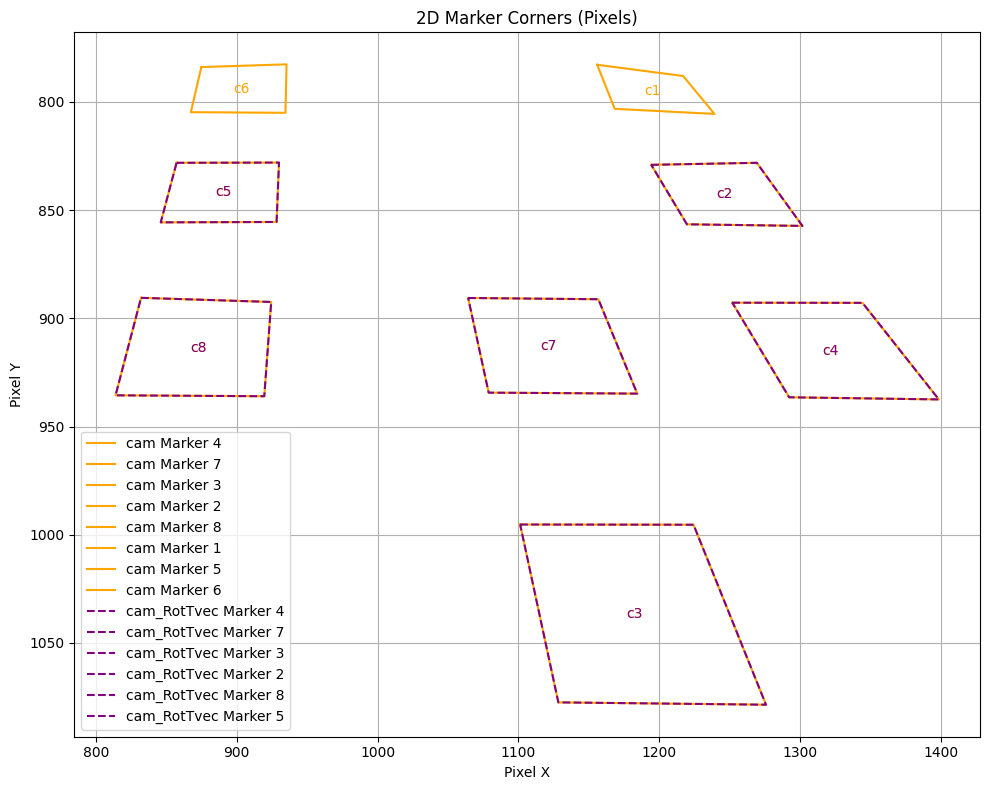

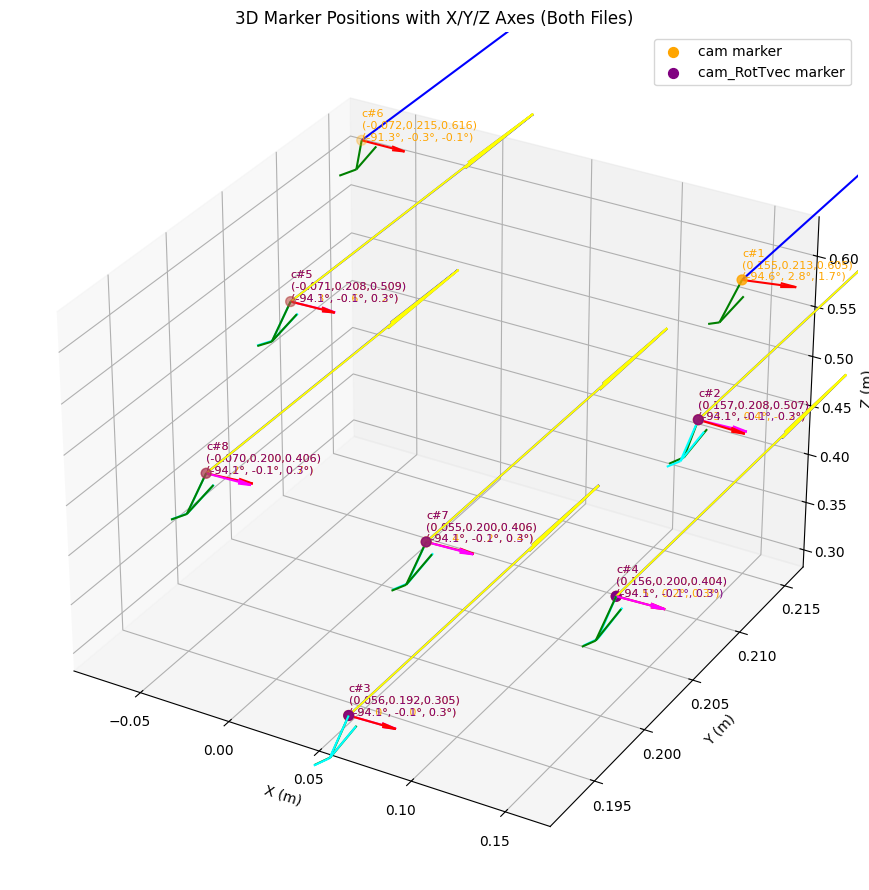

In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R

# 파일 경로
json_path1 = "./Correct_ArUco/front_leftcam_corrected.json"
json_path2 = "./Rot_Tvec_corrected_ArUco/front_leftcam_RotTvec_corrected.json"

with open(json_path1, 'r') as f:
    marker_data1 = json.load(f)
with open(json_path2, 'r') as f:
    marker_data2 = json.load(f)

# 파일별 시각화 옵션
file_infos = [
    {"data": marker_data1, "label": "cam", "color": "orange", "linestyle": "-", "axis_colors": {'x': 'red', 'y': 'green', 'z': 'blue'}},
    {"data": marker_data2, "label": "cam_RotTvec", "color": "purple", "linestyle": "--", "axis_colors": {'x': 'magenta', 'y': 'cyan', 'z': 'yellow'}}
]

# 1) 2D 시각화 (Pixel 기준)
fig, ax = plt.subplots(figsize=(10, 8))
for info in file_infos:
    for marker_id, data in info["data"].items():
        corners = np.array(data["corners_pixel"])
        poly = np.vstack([corners, corners[0]])
        ax.plot(poly[:, 0], poly[:, 1], label=f'{info["label"]} Marker {marker_id}', color=info["color"], linestyle=info["linestyle"])
        center = corners.mean(axis=0)
        ax.text(center[0], center[1], f'{info["label"][0]}{marker_id}', fontsize=10, ha='center', va='center', color=info["color"])

ax.set_xlabel('Pixel X')
ax.set_ylabel('Pixel Y')
ax.set_title('2D Marker Corners (Pixels)')
ax.invert_yaxis()
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) 3D 위치 + 회전 축 시각화
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

for info in file_infos:
    positions = []
    labels = []
    rotated_axes = {'x': [], 'y': [], 'z': []}
    unit_axes = {'x': np.array([1, 0, 0]), 'y': np.array([0, 1, 0]), 'z': np.array([0, 0, 1])}

    for marker_id, data in info["data"].items():
        pos = data["position_m"]
        quat = data["rotation_quat"]
        r = R.from_quat([quat["x"], quat["y"], quat["z"], quat["w"]])
        positions.append([pos["x"], pos["y"], pos["z"]])
        labels.append(marker_id)
        for axis, unit_vec in unit_axes.items():
            rotated = r.apply(unit_vec)
            rotated_axes[axis].append(rotated)
    positions = np.array(positions)
    for axis in rotated_axes:
        rotated_axes[axis] = np.array(rotated_axes[axis])

    # 산점도 및 회전축
    ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c=info["color"], s=50, label=f'{info["label"]} marker')
    for i, label in enumerate(labels):
        for axis in ['x', 'y', 'z']:
            ax.quiver(
                positions[i, 0], positions[i, 1], positions[i, 2],
                rotated_axes[axis][i, 0], rotated_axes[axis][i, 1], rotated_axes[axis][i, 2],
                length=0.025, color=info["axis_colors"][axis])
        # 위치 및 회전 텍스트 추가
        x, y, z = positions[i]
        quat = info["data"][label]["rotation_quat"]
        r = R.from_quat([quat["x"], quat["y"], quat["z"], quat["w"]])
        euler_deg = r.as_euler('xyz', degrees=True)  # XYZ 순서, deg로 변환
        ex, ey, ez = euler_deg

        ax.text(
            x, y, z,
            f'{info["label"][0]}#{label}\n({x:.3f},{y:.3f},{z:.3f})\n({ex:.1f}°, {ey:.1f}°, {ez:.1f}°)',
            color=info["color"],
            fontsize=8
        )


ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('3D Marker Positions with X/Y/Z Axes (Both Files)')
ax.legend()
plt.tight_layout()
plt.show()
